In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5 

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance


CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [2]:
######### Step 1: Hyperparameter tuning round 1 WITH OVERSAMPLING not "balanced" weights

model_rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf=5, max_features = 'sqrt', random_state = 10)
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

## tuning just on training data
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]

X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

## what if tuned in all data?
#X_train = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
#y_train = 1 - CIP_data_no_drop['Susceptible']
#X_train, y_train = oversample.fit_resample(X_train,y_train) ## need to resample even if I'm doing the entire dataset? Cos the model needs to be fit 

### parameters for search
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
space = dict()
space['n_estimators'] = np.arange(100, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 25, 1)
space['min_samples_leaf'] = np.arange(1, 25, 1)


## find hyperparameters
search = RandomizedSearchCV(model_rf, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Hyperparameters:  {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 61}


Best Score: 0.877938683132499
Best Hyperparameters: {'n_estimators': 171, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 89}


In [3]:
##### Step 2: FEATURE ENGINEERING
## get better results using oversampling, not balanced dataset
#Best Hyperparameters:  {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 61}

model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)


## Temporal split training data 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

model_fit = model_rf.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_rf.predict(X_test)

ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) ## why is this higher than when I remove features?

perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ROC_AUC_rf: 0.6340716423354156


Weight,Feature
0.0333 ± 0.0025,PREV_CLINIC
0.0159 ± 0.0007,MSM
0.0073 ± 0.0023,MSW
0.0035 ± 0.0004,Southeast
0.0003 ± 0.0003,Oth/Unk/Missing
0.0003 ± 0.0003,MSMW
0.0002 ± 0.0007,DELTA_REGION
-0.0002 ± 0.0005,West
-0.0003 ± 0.0007,Midwest
-0.0012 ± 0.0005,Southwest


In [25]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}" #works cos they are in same order as the x columns
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

Prev. Clinic0.033 +/- 0.002
MSM     0.015 +/- 0.001
MSW     0.007 +/- 0.001
Southeast0.003 +/- 0.000
Midwest 0.001 +/- 0.001
Oth/Unk/Missing0.000 +/- 0.000
West    0.000 +/- 0.000
MSMW    0.000 +/- 0.000
Change  -0.000 +/- 0.001
Southwest-0.001 +/- 0.000
Northeast-0.001 +/- 0.000
Prev. Region-0.002 +/- 0.001


([<matplotlib.axis.YTick at 0x179416530>,
 [Text(0, 0, 'Prev. Clinic'),
  Text(0, 1, 'MSM'),
  Text(0, 2, 'MSW'),
  Text(0, 3, 'Southeast'),
  Text(0, 4, 'Midwest'),
  Text(0, 5, 'Oth/Unk/Missing'),
  Text(0, 6, 'West'),
  Text(0, 7, 'MSMW'),
  Text(0, 8, 'Change'),
  Text(0, 9, 'Southwest'),
  Text(0, 10, 'Northeast'),
  Text(0, 11, 'Prev. Region')])

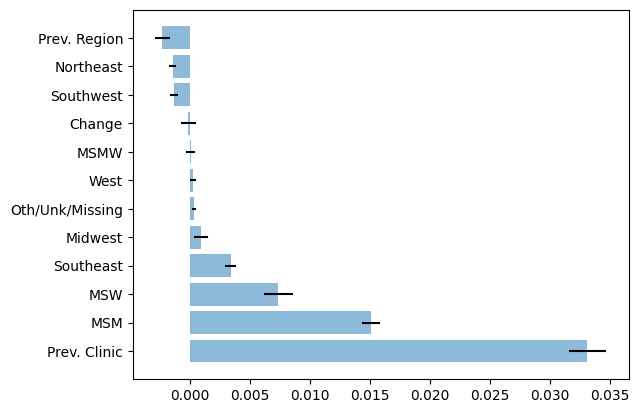

In [26]:
### graph feature engineering results 
feature_names = np.array(feature_names)
feature_names_by_importance = feature_names[PI.importances_mean.argsort()[::-1]]
mean_importance_by_importance = PI.importances_mean[PI.importances_mean.argsort()[::-1]]
std_importance_by_importance = PI.importances_std[PI.importances_mean.argsort()[::-1]]

plt.barh(y = range(mean_importance_by_importance.size), width =mean_importance_by_importance,
 xerr= std_importance_by_importance, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
plt.yticks(range(feature_names_by_importance.size), feature_names_by_importance)

#plt.savefig('Graphs/Features_by_importance_post_hyperparameter_random_forest.png')

In [4]:
##### HYPERPARAMETER TUNING without  prev_region, southwest, northeast

model_rf = RandomForestClassifier(n_estimators = 161, min_samples_split = 2, min_samples_leaf=1, max_features = 'sqrt', max_depth = 61, random_state = 10)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Southeast',  'West', 'Midwest','PREV_CLINIC', 'DELTA_REGION']

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing', 'Southeast',  'West', 'Midwest', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
### parameters for search
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
space = dict()
space['n_estimators'] = np.arange(100, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 25, 1)
space['min_samples_leaf'] = np.arange(1, 25, 1)
search = RandomizedSearchCV(model_rf, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)

result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#Best Hyperparameters: {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 61}



Best Score: 0.8779604949394924
Best Hyperparameters: {'n_estimators': 171, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 89}


In [38]:
###### Specificity and sensitivity of model on entire dataset
###### Dropping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

#loop setup
threshold_seq = np.linspace(0,1,101)

feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Southeast',  'West', 'Midwest','PREV_CLINIC', 'DELTA_REGION']
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[feature_names]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[feature_names]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_rf.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) 
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)

ROC_AUC_rf: 0.6203104695984067


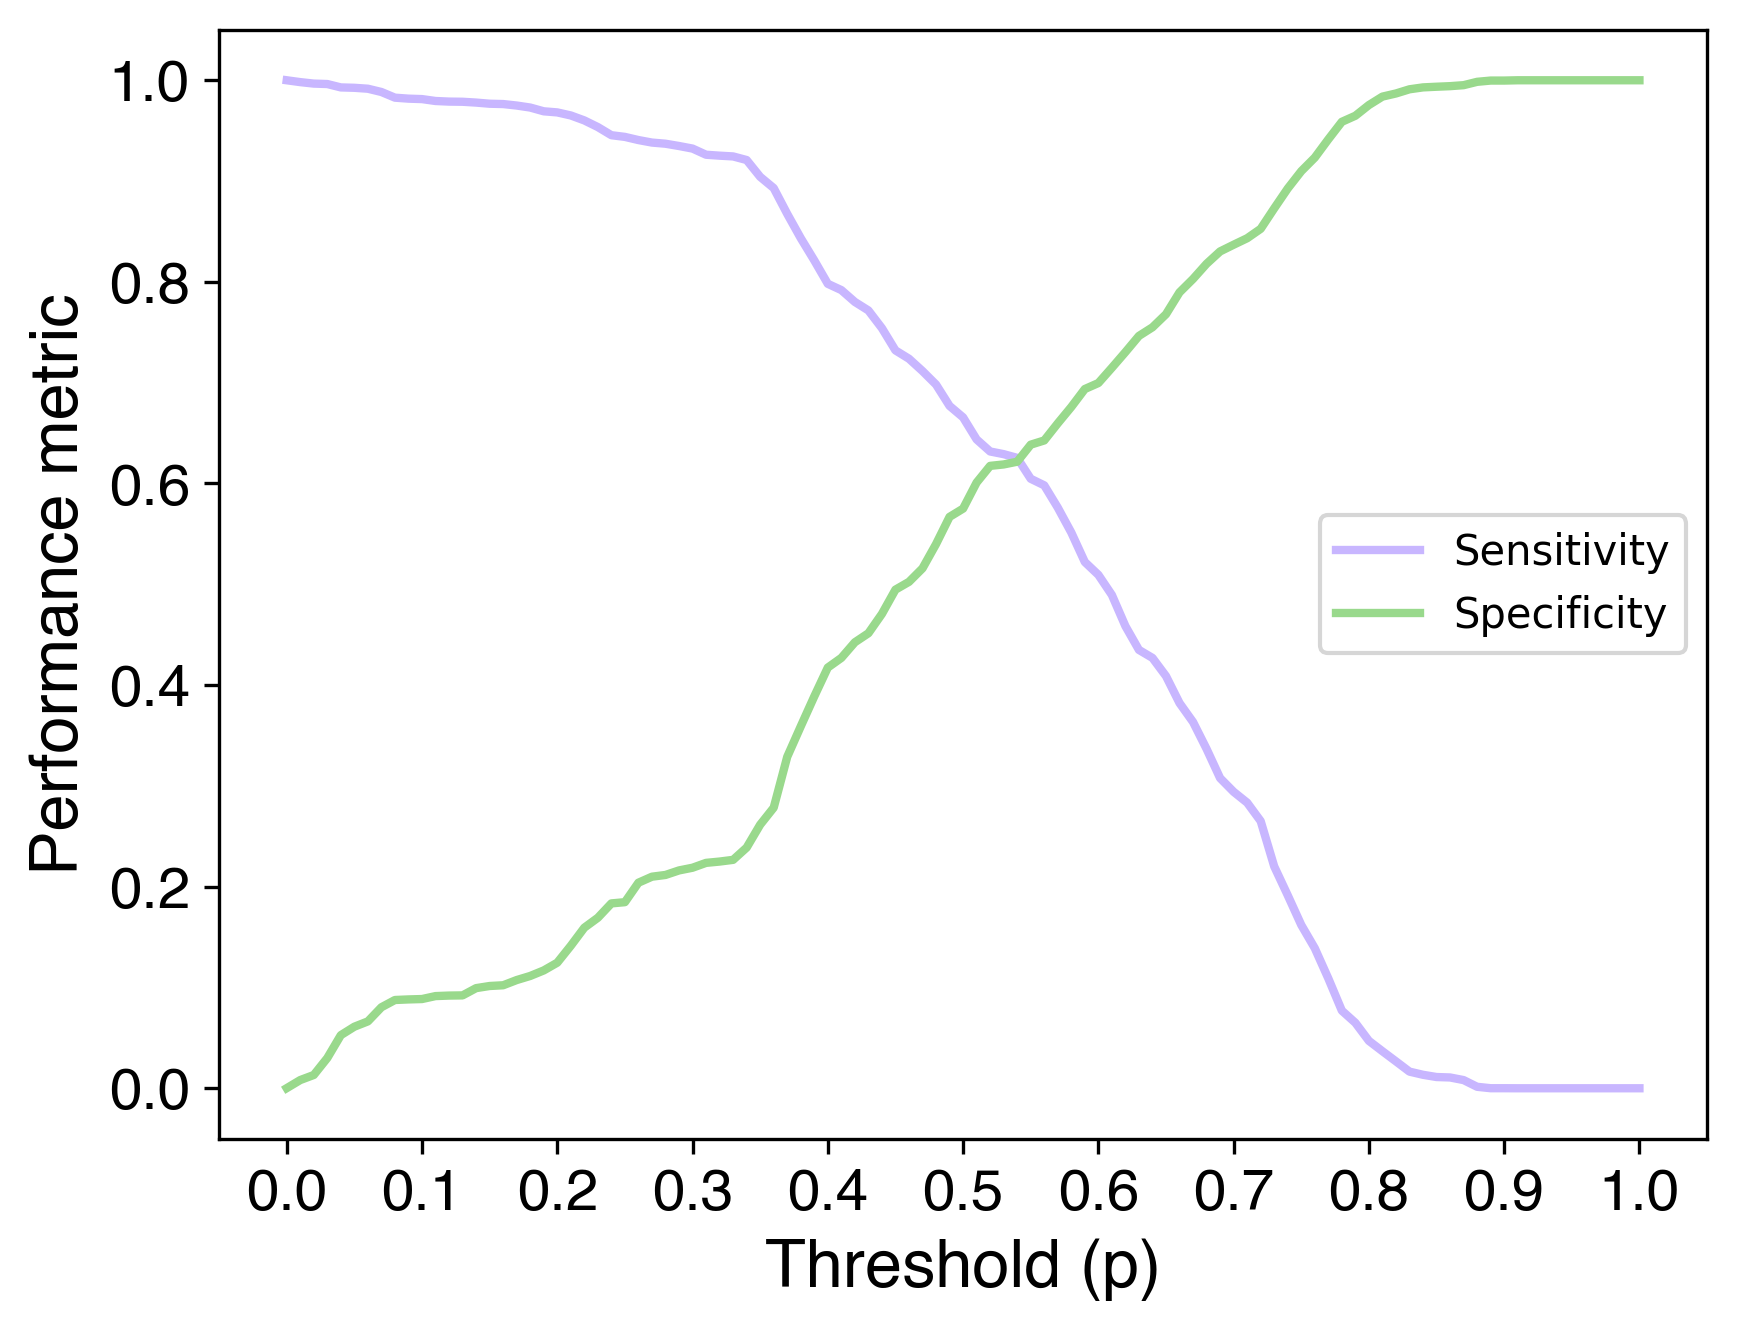

In [39]:
##### Graph of sensitivity and specificity 
hfont = {'fontname':'Helvetica'}

plt.rcParams['figure.dpi'] = 300
#plt.figure(figsize=(5.4,3.8))
sensitivity_test_threshold = pd.DataFrame(sensitivity_test_threshold)
specificity_test_threshold = pd.DataFrame(specificity_test_threshold)
threshold_seq = np.linspace(0,1,101)

plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold (p)", fontsize=16, **hfont)
plt.ylabel("Performance metric", fontsize=16,**hfont)
plt.xticks(np.linspace(0,1,11), fontsize=14,**hfont)
plt.yticks(np.linspace(0,1,6), fontsize=14,**hfont)

plt.legend()
#plt.savefig('Graphs/Sensitivity_specificity_all_workflow_paper_random_forest.png')

In [42]:
########### Now do proportion receiving effective and unnecessary treatment for overall testing data
### can use model from the previous cells
###### Cipro prevalence 2011-2019


cipro_R_prev_all= ((1 - test_data['Susceptible']).sum())/len(test_data['Susceptible']) #get prevalence overall before radndom oversampling
print(cipro_R_prev_all)
### Loop over thresholds to see how classification threshold affects proportion receiving effective and unnecessary treatment ALL TEST DATA
threshold_seq = np.linspace(0,1,101)

get_effective_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  get_effective_threshold.append(sensitivity_test * cipro_R_prev_all + (1 -  cipro_R_prev_all)) #q_p
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_all) * (1 - specificity_test)) #c_p

0.23081886682486158


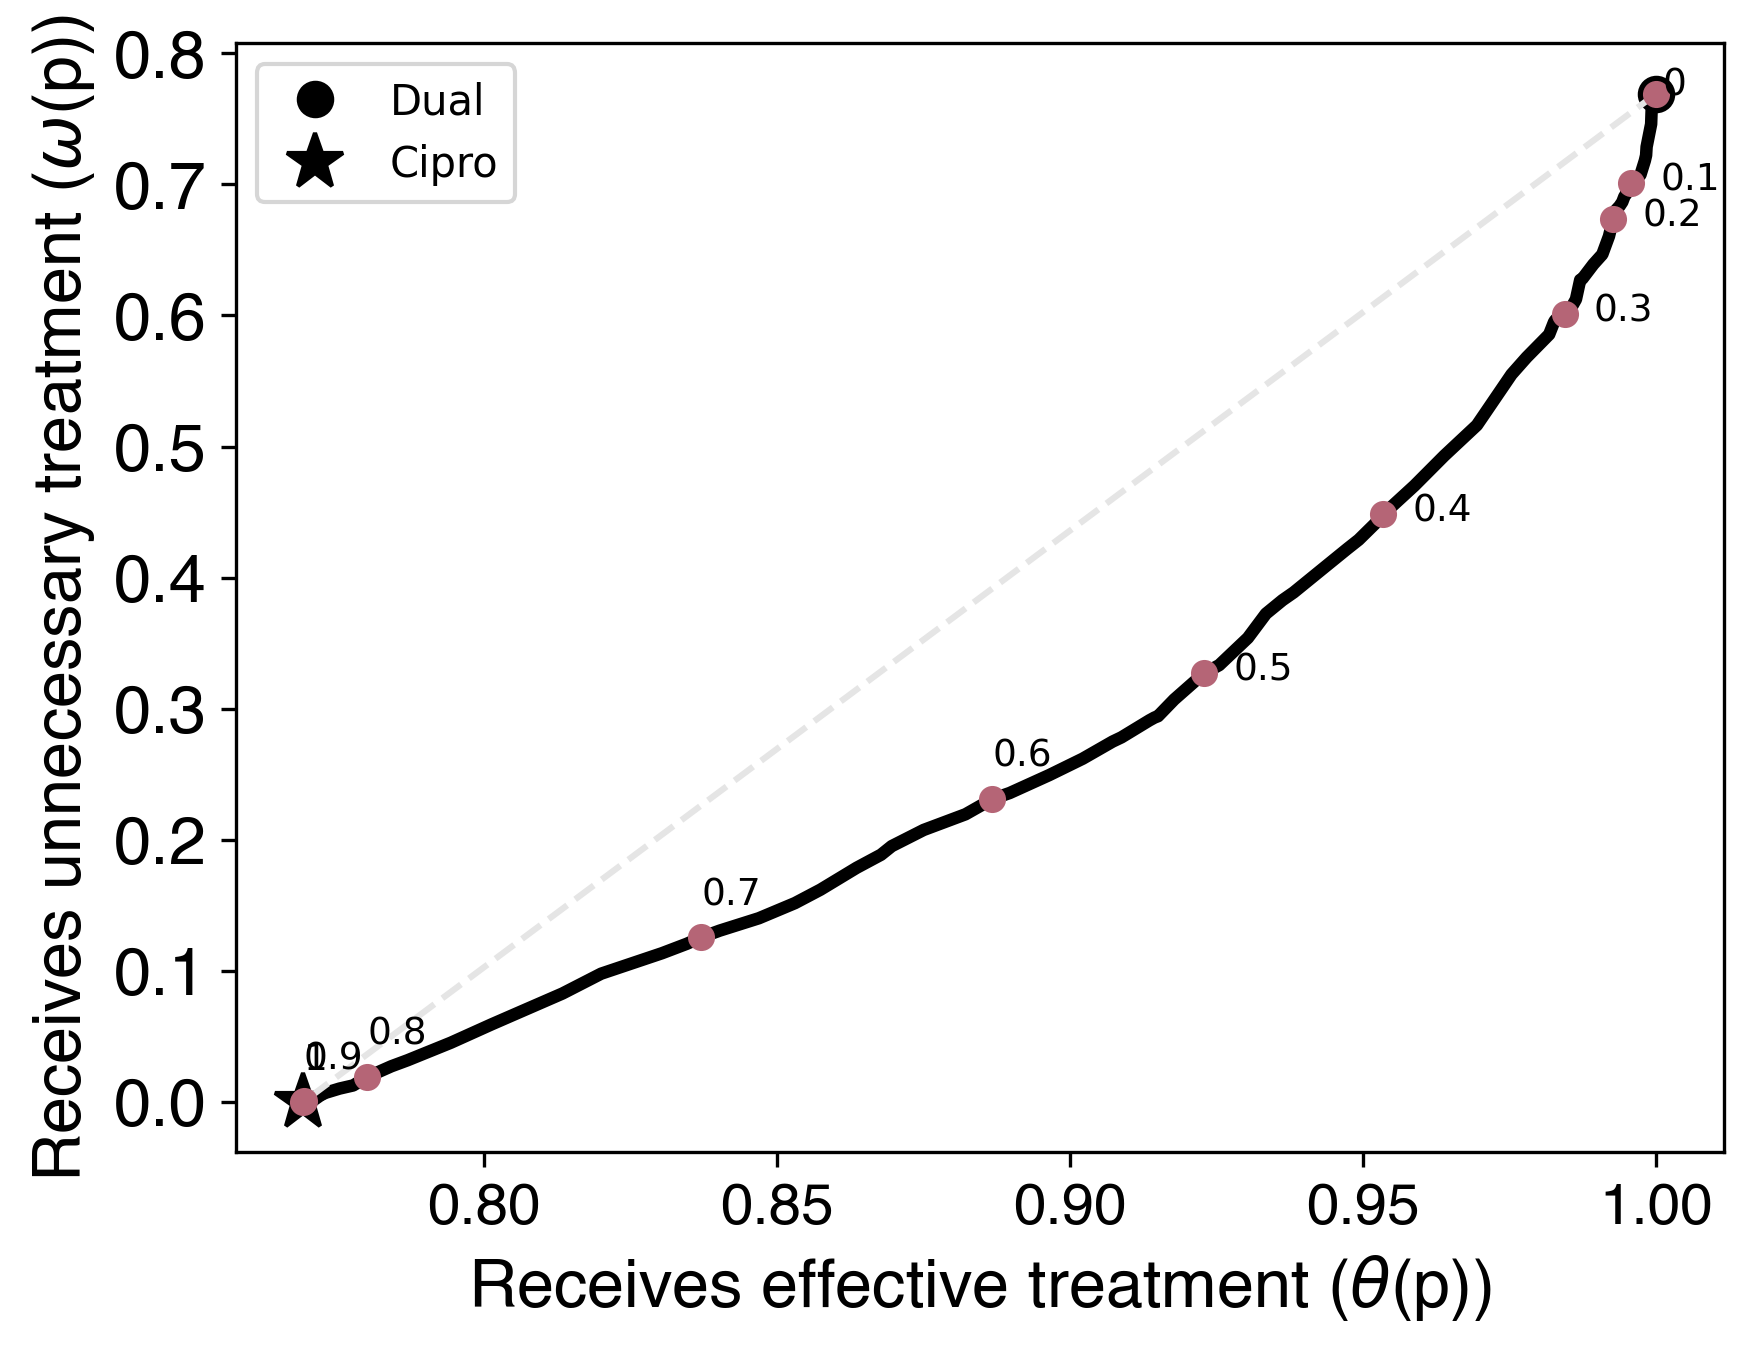

In [43]:
### Plotting overall proportion receiving effective and unnecessary treatment with all training data 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)

plt.xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
plt.ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
plt.xticks(np.linspace(0,1,21), fontsize=14, **hfont)
plt.yticks(np.linspace(0,1,11), fontsize=16, **hfont)

plt.rcParams['figure.dpi'] = 300

plt.plot(1, 1 - cipro_R_prev_all, marker='.', ls='none', ms=16, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_all), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
plt.plot([1, 1-cipro_R_prev_all], [1-cipro_R_prev_all, 0], color = "#e5e5e5", linestyle="--")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
    if get_effective_threshold[index] > 0.996:
        plt.text(get_effective_threshold[index] + 0.001, incorrectly_get_X_threshold[index] - 0.001, text_for_graph[x], size = 9)
    elif (get_effective_threshold[index] > 0.9) & (get_effective_threshold[index] < 0.996):
        plt.text(get_effective_threshold[index] + 0.005, incorrectly_get_X_threshold[index] - 0.005, text_for_graph[x], size = 9)
    else:
        plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x], size = 9)
    x = x+1

#plt.savefig('Graphs/Proportion_effective_unnecessary_all_workflow_paper_random_forest.png')

In [46]:
########### Try functionalised RF w/hyperparameter tuning and feature engineering 


def effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prevalence):

    get_effective_threshold = []
    incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
  
        get_effective_threshold.append(sensitivity_test * cipro_R_prevalence + (1 -  cipro_R_prevalence)) #q_p
        incorrectly_get_X_threshold.append((1 - cipro_R_prevalence) * (1 - specificity_test)) #c_p"
    return(get_effective_threshold, incorrectly_get_X_threshold)

def get_best_hyperparameters(model, cv, space, X_train, y_train):
        search = RandomizedSearchCV(model, space, scoring='roc_auc', n_iter=1,  n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return(result.best_params_)

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - 2 * PI.importances_std[q] > 0:
          important_features.append(feature_names[q]) #works cos they are in same order as the x columns
    return(important_features)


oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)

def get_test_train_data_rf(CIP_data_no_drop, year, feature_names, oversample_size):
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    cipro_R = y_test.sum()/len(y_test) 
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    return(test_data, train_data, X_train, y_train, X_test, y_test, cipro_R)

x
x


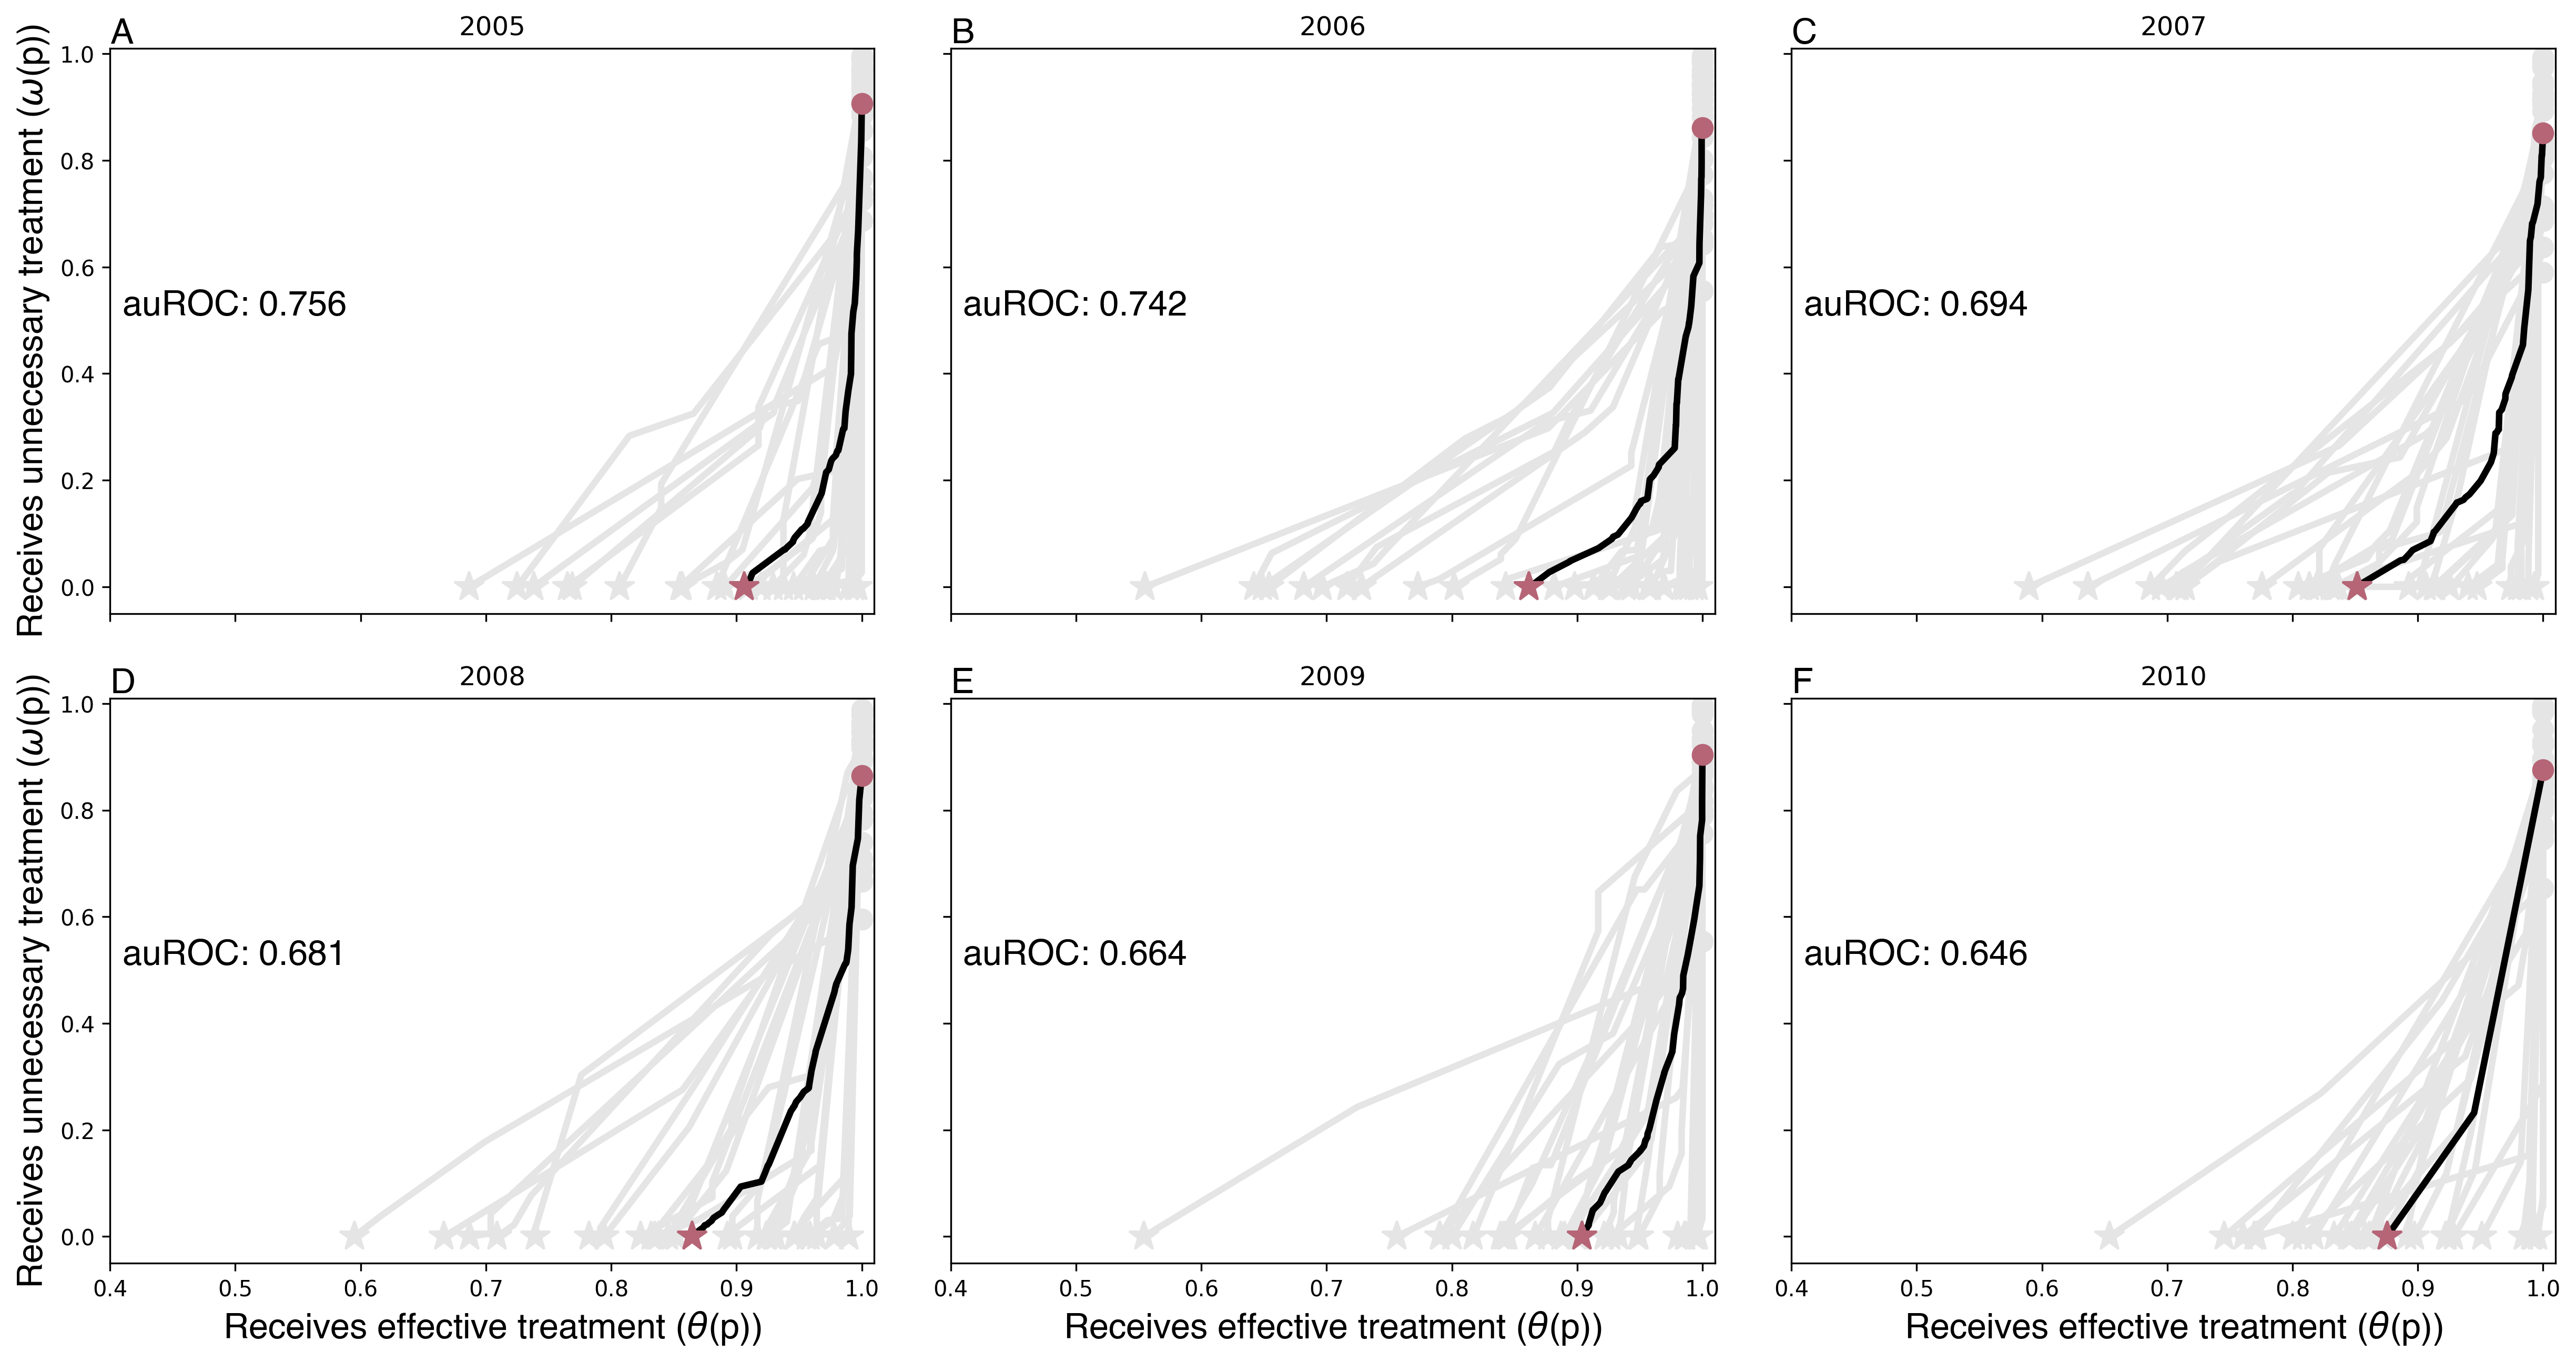

In [51]:
####### Try this with LOOCV as "error bars" AND LOOCV... May be messy and long

########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
### has LOOCV 

model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

#loop setup
threshold_seq = np.linspace(0,1,101)

feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Southeast',  'West', 'Midwest','PREV_CLINIC', 'DELTA_REGION']
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[feature_names]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[feature_names]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

### needed for hyperparameter tuning 
### parameters for search
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
space = dict()
space['n_estimators'] = np.arange(100, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 25, 1)
space['min_samples_leaf'] = np.arange(1, 25, 1)

## need for feature engineerig 
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']


#### Loop set up 
threshold_seq = np.linspace(0,1,101)

test_years = [2005, 2006, 2007, 2008, 2009, 2010]

labels = ["A", "B", "C", "D", "E", "F" ]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

### hyperparameters by year 
best_hyperparameters_by_year = {}
### best features by year
best_features_by_year = {}
### ROC by year 
ROC_by_year = {}

fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_rf(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, oversample_size = 0.5)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    best_hyperparameters_by_year.__setitem__(year, best_hyperparameters) 

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters['n_estimators'], min_samples_split = best_hyperparameters['min_samples_split'], min_samples_leaf=best_hyperparameters['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters['max_depth'], random_state = 10)

     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train)
    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year.__setitem__(year, important_features) 

    # get new tets/train data and refit model 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_rf(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, oversample_size = 0.5)


    ## fit model w/hyperparameters 
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year.__setitem__(year, ROC)

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[important_features]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[important_features]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 0.85,random_state=42)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              
              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")

            except ValueError:
              print('x')
              pass
    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "#b56576")
    axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "#b56576")

    axs[i].set_ylim([0-0.05,1.01])
    axs[i].set_xlim([0.4, 1.01])
    axs[i].text(axs[i].get_xlim()[0] + 0.01 , axs[i].get_ylim()[1] - 0.5, f'auROC: {round(ROC, 3)}', fontsize = 16, **hfont)

    if (i == 0) | (i == 3):
        axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
    if(i == 3) | (i == 4) | (i == 5):
        axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
    axs[i].title.set_text(year)

    i += 1   #
#plt.savefig('Graphs/Proportion_effective_unnecessary_2006_2011_all_LOOCV_workflow_paper_random_forest.png')


In [34]:
#performance metrics on training set of 2000-2010 and test set of 2011-2019 without west and southeast and with tuned hyperparameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
# using all featurs (above) gives better auROC score...
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Southeast',  'West', 'Midwest','PREV_CLINIC', 'DELTA_REGION']

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[feature_names]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[feature_names]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

model_fit_train = model_rf.fit(X_train, y_train)

  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

###ROC 
ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) 

###F1 score

tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict).ravel()

precision = tp_test/(tp_test + fp_test)
recall = tp_test/(tp_test + fn_test)
f1_score = 2/(1/precision + 1/recall)
print("F1_me: ", f1_score)
###

from sklearn.metrics import f1_score

print("F1", f1_score(y_test, y_predict))
print("F1 macro: ", f1_score(y_test, y_predict, average = "macro"))

### MCC score
from sklearn.metrics import matthews_corrcoef
import math

MCC_me = ((tp_test*tn_test) - (fp_test*fn_test))/math.sqrt((tp_test + fp_test)*(tp_test + fn_test)*(tn_test + fp_test)*(tn_test + fn_test))
print("MCC:", MCC_me)

print("MCC:", matthews_corrcoef(y_test, y_predict))


## specificity and sensitivity for threshold = 0.5 

sensitivity_test  = tp_test  / (tp_test   + fn_test )
specificity_test   = tn_test / (tn_test + fp_test )

print("Sensitivity: ", sensitivity_test)
print("Specificity: ", specificity_test)

ROC_AUC_rf: 0.6203104695984067
F1_me:  0.5291763490833978
F1 0.5291763490833978
F1 macro:  0.5946493717707382
MCC: 0.22687061194759015
MCC: 0.22687061194759015
Sensitivity:  0.6655661398571119
Specificity:  0.5750547993397018
